# This notebook walks the reader through icon detection and their classification

##### The detection code borrows heavily from - https://github.com/longcw/faster_rcnn_pytorch

In [1]:
from __future__ import print_function
import os
import torch
import cv2
import sys
import json
import random
import glob
import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib
import pickle as pickle
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import numpy as np
import os
from tqdm import trange, tqdm
from progressbar import ProgressBar
from faster_rcnn import network
from faster_rcnn.faster_rcnn import FasterRCNN, RPN
from faster_rcnn.utils.timer import Timer
from faster_rcnn.fast_rcnn.nms_wrapper import nms
from faster_rcnn.fast_rcnn.bbox_transform import bbox_transform_inv, clip_boxes
from faster_rcnn.datasets.factory import get_imdb
from faster_rcnn.fast_rcnn.config import cfg, cfg_from_file, get_output_dir
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from pycrayon import CrayonClient
import sys
sys.path.append('/data/graphics/SpandanGraphsProject/Spandan_Experiments/icon_classification/')
from ImageFolder_resized import ImageFolder_resized
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = [14.0,8.0]

# HYPER PARAMETERS

In [2]:
INPUT_FILE = "sample_images/wine-vs-beer-infographic.jpg"
IM_SAVE_NAME = 'sample_outputs/DEMO_SAVE.png'
CUDA = True

In [3]:
def vis_detections(im, class_name, dets, gt_boxes, thresh=0.8):
    """Visual debugging of detections."""
    placed_bboxes = []
    for i in range(dets.shape[0]):
        bbox = tuple(int(np.round(x)) for x in dets[i, :4])
        score = dets[i, -1]
        if score > thresh:
            cv2.rectangle(im, bbox[0:2], bbox[2:4], (204, 0, 0), 2)
#             cv2.putText(im, '%s' % (i), (bbox[0], bbox[1] + 15), cv2.FONT_HERSHEY_PLAIN,
#                         1.0, (250, 0, 0), thickness=2)
            placed_bboxes.append(bbox)
    if gt_boxes is not None:
        overlay = im.copy()
        for gt_box in gt_boxes:
            bbox = tuple(int(np.round(x)) for x in gt_box)
            cv2.rectangle(overlay, bbox[0:2], bbox[2:4], (0, 204, 0), 2)
        opacity = 0.4
        cv2.addWeighted(im, opacity, overlay, 1 - opacity, 0, im)
    return im,placed_bboxes
def filter_boxes(im, scores, boxes, gt_boxes, max_per_image, thresh, vis_thresh, classes = ['__background__','icon']):

    im2show = np.copy(im)

    # skip j = 0, because it's the background class
    for j in xrange(1, len(classes)):
        inds = np.where(scores[:, j] > thresh)[0]
        cls_scores = scores[inds, j]
        cls_boxes = boxes[inds, j * 4:(j + 1) * 4]
        cls_dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])) \
            .astype(np.float32, copy=False)
        keep = nms(cls_dets, cfg.TEST.NMS)
        cls_dets = cls_dets[keep, :]
        im2show,placed_bboxes = vis_detections(im2show, classes[j], cls_dets, gt_boxes, vis_thresh)

    return im2show, cls_dets
def im_detect(net, image):
    """Detect object classes in an image given object proposals.
    Returns:
        scores (ndarray): R x K array of object class scores (K includes
            background as object category 0)
        boxes (ndarray): R x (4*K) array of predicted bounding boxes
    """

    im_data, im_scales = net.get_image_blob(image)
    im_info = np.array(
        [[im_data.shape[1], im_data.shape[2], im_scales[0]]],
        dtype=np.float32)

    cls_prob, bbox_pred, rois = net(im_data, im_info)
    scores = cls_prob.data.cpu().numpy()
    boxes = rois.data.cpu().numpy()[:, 1:5] / im_info[0][2]

    if cfg.TEST.BBOX_REG:
        # Apply bounding-box regression deltas
        box_deltas = bbox_pred.data.cpu().numpy()
        pred_boxes = bbox_transform_inv(boxes, box_deltas)
        pred_boxes = clip_boxes(pred_boxes, image.shape)
    else:
        # Simply repeat the boxes, once for each class
        pred_boxes = np.tile(boxes, (1, scores.shape[1]))
    return scores, pred_boxes
def get_crops(im, n, overlap):
    if n == 1:
        sc_size = 1
        sc_ov = 0
    elif n == 2:
        sc_size = .5 + overlap
        sc_ov = overlap
    else:
        sc_size = (.5 + overlap) / float(1 + (n-1)*overlap + (n-2)*(.5-overlap))
        sc_ov = overlap / float(1 + (n-1)*overlap + (n-2)*(.5-overlap))
    im_width = int(im.shape[0] * sc_size)
    im_height = int(im.shape[1] * sc_size)
    ov_width = int(im.shape[0] * sc_ov)
    ov_height = int(im.shape[1] * sc_ov)
    images = []
    crop_offset = []
    for i in range(n):
        for j in range(n):
            sx = i * im_width - (i) * ov_width
            sy = j * im_height - (j) * ov_height
            images.append(im[sx:sx + im_width, sy:sy + im_height])
            crop_offset.append([sy,sx,sy,sx])
    return images, crop_offset
def pyramid_process(image, thresh, vis_thresh, overlap, levels, feed_size=600, nms_thresh=cfg.TEST.NMS):
    comp_boxes = None
    for level in range(levels):
        crops, crop_offset = get_crops(image,level+1,overlap)
        for i, crop in enumerate(crops):
            scale_factor = feed_size / float(min(crop.shape[0],crop.shape[1]))
            scaled_image = cv2.resize(crop, (0,0), fx=scale_factor, fy=scale_factor)
            scores, boxes = im_detect(net, scaled_image)
            im2show, filtered_boxes = filter_boxes(scaled_image, scores, boxes, None, 50, thresh, vis_thresh)
            filtered_boxes[:,:4] /= scale_factor
            filtered_boxes[:,:4] += crop_offset[i]
            comp_boxes = filtered_boxes if comp_boxes is None else np.concatenate((comp_boxes, filtered_boxes), axis=0)
    keep = nms(comp_boxes, nms_thresh)
    comp_boxes = comp_boxes[keep, :]
    return comp_boxes

def area(a, b): 
    dx = min(a[2], b[2]) - max(a[0], b[0])
    dy = min(a[3], b[3]) - max(a[1], b[1])
    base_area = (a[0]-a[2])*(a[1]-a[3])
    if (dx>=0) and (dy>=0):
        return dx*dy/float(base_area)
    else:
        return 0

# ICON DETECTION

In [4]:
trained_model = 'saved_models/faster_rcnn_30000.h5'
version = 'v3'
###
imdb_name = 'icon_val'
cfg_file = 'config_files/faster_rcnn_end2end.yml'

cfg_from_file(cfg_file)

# load data
imdb = get_imdb(imdb_name)
imdb.competition_mode(on=True)

# load net
_ = net = FasterRCNN(classes=imdb.classes, debug=False)
network.load_net(trained_model, net)
print('Loaded model successfully!')

_ = net.cuda()
_ = net.eval()
print('Model evaluated successfully!')


value_dict = {'v1':(.6,3),'v2':(.6,4),'v3':(.8,3),'v4':(.8,4),'v5':(.9,3),'v6':(.9,4),'v7':(.95,3),'v8':(.95,4)}
(vis_thresh, levels) = value_dict[version]
thresh = 0.1
overlap = .1

feed_size = 600
bgr_image = cv2.imread(INPUT_FILE)
image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
image_copy = image.copy()
# cv2.imwrite('/data/graphics/SpandanGraphsProject/matt/iconess/test_windows/res_19_clean.jpg', image)
comp_boxes = pyramid_process(image, thresh, vis_thresh, overlap, levels)
result_im,placed_bboxes = vis_detections(image, 'icon', comp_boxes, None, vis_thresh)
print('Detections done!')
#     cv2.imwrite('/data/graphics/SpandanGraphsProject/matt/iconess/test_windows/res_19_IconExp30_1000_v1_pyr.jpg', result_im)

<bound method icon.default_roidb of <faster_rcnn.datasets.icon.icon object at 0x7f8d8ccbab90>>
num_classes:2
Loaded model successfully!
Model evaluated successfully!
Detections done!


# Cleaning up overlapping detections

In [5]:
overlappers = []
overlapper_partners = []
for i in range(len(placed_bboxes)):
    bbox1 = placed_bboxes[i]
    for j in range(len(placed_bboxes)):
        bbox2 = placed_bboxes[j]
        if i != j:
            if area(bbox1,bbox2) > 0.6:
                if (j,i) not in overlapper_partners:
                    overlappers.append(i)
                    overlapper_partners.append((i,j))
                    
overlappers_list = list(set(overlappers))

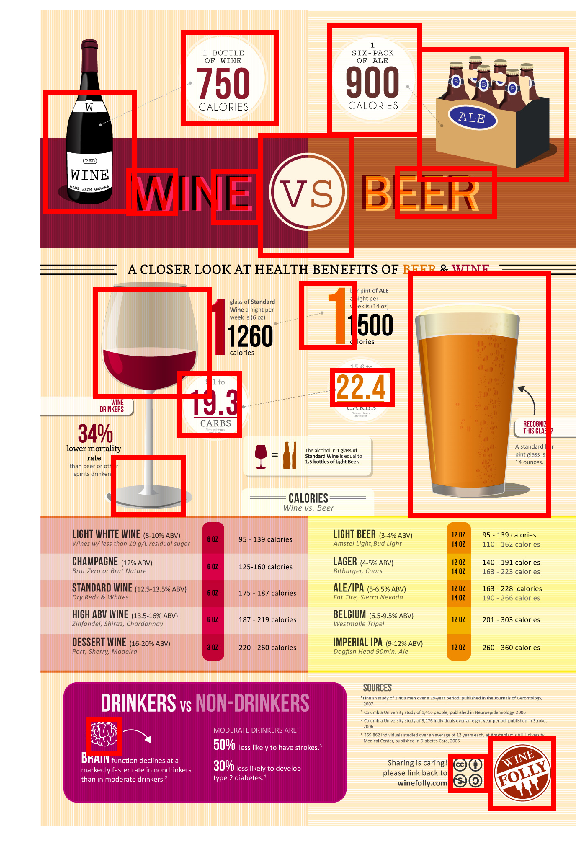

In [6]:
fig,ax = plt.subplots(1,figsize=(50,15))
ax.imshow(image_copy); plt.axis('off')

for j in range(len(placed_bboxes)):
    if j not in overlappers_list:
        bbox = placed_bboxes[j]
        left,top,right,bottom = bbox
        width = right - left
        height = bottom - top
        rect_icon = patches.Rectangle((left,top), width, height, facecolor='none',linewidth=5,edgecolor='red')
        ax.add_patch(rect_icon)

# Saving file

In [7]:
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(IM_SAVE_NAME,bbox_inches=extent)

In [8]:
impil = Image.fromarray(image_copy)

# Classifying icon detections

In [9]:
NUM_CLASSES = 391
f = open('config_files/classes_list_391.txt','r')
content = f.readlines()
f.close()
all_classes = [c.rstrip() for c in content]

model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)
checkpoint = torch.load('saved_models/classification_model.pt')
model_ft.load_state_dict(checkpoint)

if CUDA:
    torch.cuda.set_device(0)
    model_ft.cuda();
    model_ft.eval();

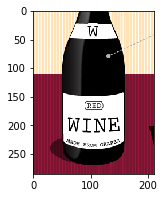

Predicted categories are -  ['men', 'uk', 'election']


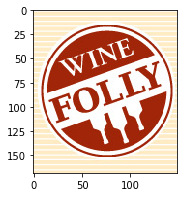

Predicted categories are -  ['election', 'unemployment', 'black_friday']


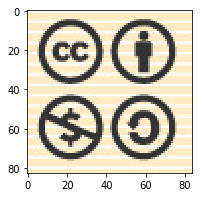

Predicted categories are -  ['calorie', 'health_insurance', 'supplement']


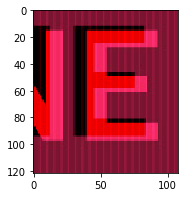

Predicted categories are -  ['brand', 'real_estate', 'property']


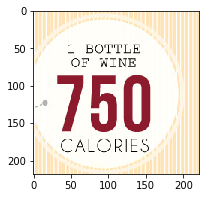

Predicted categories are -  ['sales', 'typography', 'social_media']


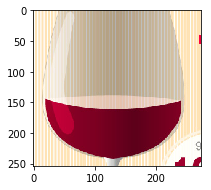

Predicted categories are -  ['asia', 'germany', 'spain']


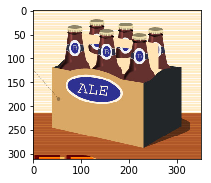

Predicted categories are -  ['retail', 'shopping', 'software']


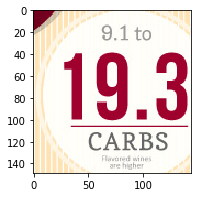

Predicted categories are -  ['gdp', 'social', 'unemployment']


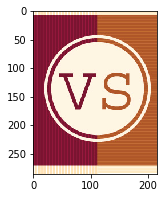

Predicted categories are -  ['budget', 'coupon', 'calorie']


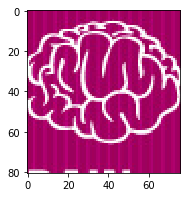

Predicted categories are -  ['healthcare', 'disease', 'brain']


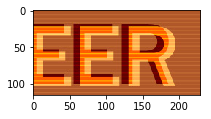

Predicted categories are -  ['kitchen', 'hotel', 'interior_design']


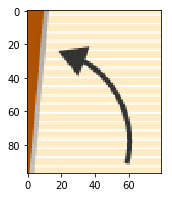

Predicted categories are -  ['resume', 'security', 'engagement']


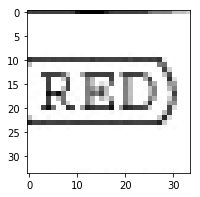

Predicted categories are -  ['auto', 'automotive', 'vehicle']


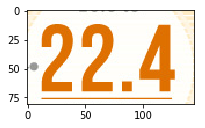

Predicted categories are -  ['gdp', 'humor', 'calorie']


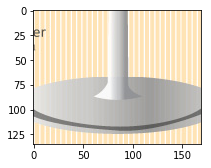

Predicted categories are -  ['president', 'politics', 'congress']


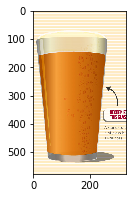

Predicted categories are -  ['chocolate', 'coffee', 'drink']


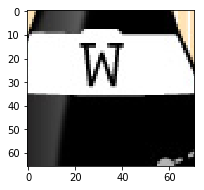

Predicted categories are -  ['culture', 'diy', 'airport']


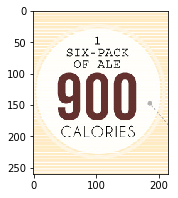

Predicted categories are -  ['politics', 'poster', 'typography']


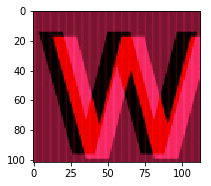

Predicted categories are -  ['video_game', 'new_york_city', 'celebrity']


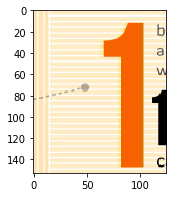

Predicted categories are -  ['history', 'poster', 'flowchart']


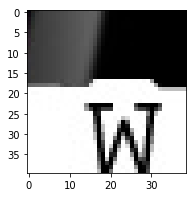

Predicted categories are -  ['tv', 'interior_design', 'video_game']


In [12]:
from PIL import Image

preprocess = transforms.Compose([
   transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

impil = Image.fromarray(image_copy)
np_out_icons = np.zeros((len(placed_bboxes),391))
predictions = []
top_2_preds = {}

for i in range(len(placed_bboxes)):
    bbox = placed_bboxes[i]
    im_crop = impil.crop(bbox)
    im_resized = im_crop.resize((224,224))
    im_tensor = preprocess(im_resized)
    im_unsqueezed = Variable(im_tensor.unsqueeze(0).cuda())
    output = model_ft(im_unsqueezed)
    np_out_icons[i] = output.cpu().data[0].numpy()
    top_pred = all_classes[np.argsort(np_out_icons[i])[-1]]
    predictions.append(top_pred)
    top_3_preds = [all_classes[K] for K in np.argsort(np_out_icons[i])[-3:]]
    fig = plt.figure(figsize=(3,3))
    plt.imshow(im_crop)
    plt.show()
    print('Predicted categories are - ',top_3_preds)
#     path_name = '/data/graphics/SpandanGraphsProject/earth_day_final_detections/xmin_%04d_ymin_%04d_xmax_%04d_ymax_%04d_score_%04d.jpg'%(bbox[0],bbox[1],bbox[2],bbox[3],980)
#     top_2_preds[path_name] = [all_classes[K] for K in np.argsort(np_out_icons[i])[-2:]]